In [1]:
import os
from itertools import product

import bdpy
from bdpy.dataform import DecodedFeatures
from bdpy.evals.metrics import profile_correlation
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

## Calculation of voxel-wise encoding accuracy

In [2]:
# Data settings

# Predicted fMRI signals
predicted_fmri_path = "./data/encoded_fmri/ImageNetTest/deeprecon_fmriprep_pyfastl2lir_alpha100_500units/caffe/VGG19_random5000"

layers = ["conv1_2", "conv2_2", "conv3_4", "conv4_4", "conv5_4", "fc6", "fc7", "fc8"]
subjects = ["sub-01", "sub-02", "sub-03"]
rois = ["V1", "V2", "V3", "hV4", "HVC"]

# Ground truth fMRI signals
gt_fmri_paths = {
    "sub-01": "./data/fmri/Deeprecon/sub-01_ImageNetTest_fmriprep_volume_native_vc.h5",
    "sub-02": "./data/fmri/Deeprecon/sub-02_ImageNetTest_fmriprep_volume_native_vc.h5",
    "sub-03": "./data/fmri/Deeprecon/sub-03_ImageNetTest_fmriprep_volume_native_vc.h5",
}

# Option
average_sample = True  # If True, average fMRI signals across trials for the same stimulus

In [3]:
# Load data

predicted_fmri = DecodedFeatures(predicted_fmri_path, file_key="fmri")
# Note: `DecodedFeatures` class is designed to handle decoded features, but it can also be used to load predicted fMRI signals here
# because the predicted fMRI signals are stored in the same format as decoded features.

gt_fmri_datas = {sub: bdpy.BData(gt_fmri_paths[sub]) for sub in subjects}  # This may take a while.
label_key = "stimulus_name"

Found 6000 decoded features in ./data/encoded_fmri/ImageNetTest/deeprecon_fmriprep_pyfastl2lir_alpha100_500units/caffe/VGG19_random5000


In [4]:
# Calculate prediction accuracy

prediction_accuracies = {}

for layer, subject, roi in product(layers, subjects, rois):
    # Extract predicted and ground truth fMRI signals as arrays
    pred_fmri = predicted_fmri.get(layer=layer, subject=subject, roi=roi)
    pred_labels = predicted_fmri.selected_label

    gt_fmri = gt_fmri_datas[subject].select(f"ROI_{roi}")
    gt_labels = gt_fmri_datas[subject].get_label(label_key)

    pred_labels = np.array(pred_labels)
    gt_labels = np.array(gt_labels)

    # [Optional] average GT fMRI signals across trials
    if average_sample:
        gt_labels_unique = np.unique(gt_labels)
        gt_fmri = np.stack([np.mean(gt_fmri[np.where(gt_labels == label)[0], :], axis=0) for label in gt_labels_unique])
        gt_labels = gt_labels_unique

    # Sort pred_fmri as gt_fmri
    sort_index = np.array([np.where(pred_labels == label)[0] for label in gt_labels]).ravel()
    pred_fmri = pred_fmri[sort_index, :]

    # Calculate prediction accuracy (voxel-wise correlation between predicted and ground truth fMRI signals; profile correlation)
    r_prof = profile_correlation(pred_fmri, gt_fmri)

    prediction_accuracies[(layer, subject, roi)] = r_prof

    # Display prediction accuracy
    #print(f"(Layer: {layer}, Subject: {subject}, ROI: {roi})\tPrediction accuracy (profile correlation): {np.mean(r_prof)}")


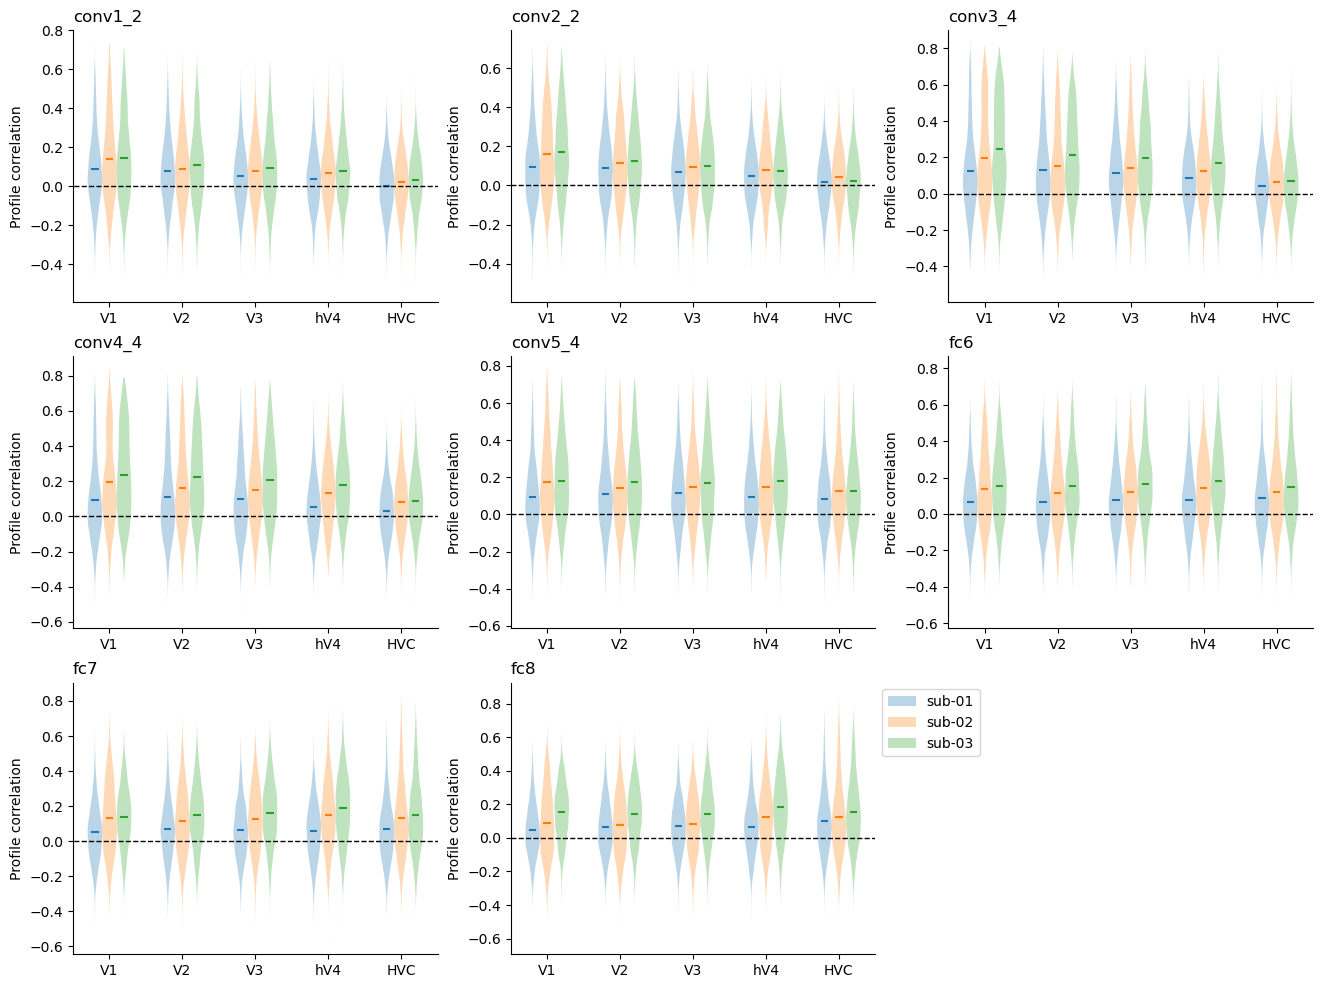

In [5]:
# Make plots

fig = plt.figure(figsize=(16, 12))

xpos = np.arange(len(rois))

for i, layer in enumerate(layers):
    ax = fig.add_subplot(3, 3, i + 1)

    handles = []
    for j, sub in enumerate(subjects):
        y = []
        for k, roi in enumerate(rois):
            r_prof = prediction_accuracies[(layer, sub, roi)]
            y.append(r_prof.ravel())
        
        p = ax.violinplot(y, positions=xpos + 0.2 * (j - 1), widths=0.2, showmeans=True, showextrema=False)
        handles.append(p["bodies"][0])

    ax.plot([-1, len(rois)], [0, 0], 'k--', linewidth=1)

    ax.set_title(layer, loc="left")
    ax.set_xlim([-0.5, len(rois) - 0.5])
    ax.set_xticks(xpos)
    ax.set_xticklabels(rois)
    ax.set_ylabel("Profile correlation")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.legend(handles, subjects, loc='upper left', bbox_to_anchor=(1, 1))

plt.show()

## Visualization of voxel-wise encoding accuracy using PyCortex

In [6]:
import cortex

In [7]:
# Check PyCortex filestore path
cortex.config["basic"]["filestore"]

'/home/dni/aoki/projects/pipeline/feature-encoding/data/pycortex'

In [8]:
# Create a PyCortex Volume object for the specified subject

subject = "sub-03"
transform = "voxel2mm_fmriprep"

bdata = gt_fmri_datas[subject]

voxel_i = bdata.get_metadata("voxel_i", where='VoxelData').astype('int32')
voxel_j = bdata.get_metadata("voxel_j", where='VoxelData').astype('int32')
voxel_k = bdata.get_metadata("voxel_k", where='VoxelData').astype('int32')

volume = cortex.Volume.empty(subject, xfmname=transform, value=np.nan)

In [13]:
# Fill the volume with prediction accuracies (visual cortex only)

layer = "fc8"

for roi in rois:
    r = prediction_accuracies[(layer, subject, roi)][0]

    voxel_i = bdata.get_metadata("voxel_i", where=f"ROI_{roi}").astype('int32')
    voxel_j = bdata.get_metadata("voxel_j", where=f"ROI_{roi}").astype('int32')
    voxel_k = bdata.get_metadata("voxel_k", where=f"ROI_{roi}").astype('int32')

    volume.data[voxel_k, voxel_j, voxel_i] = r


** (inkscape:2258078): WARNING **: 09:34:25.470: ファイル形式の自動検出が失敗しました。ファイルは SVG として開かれます。


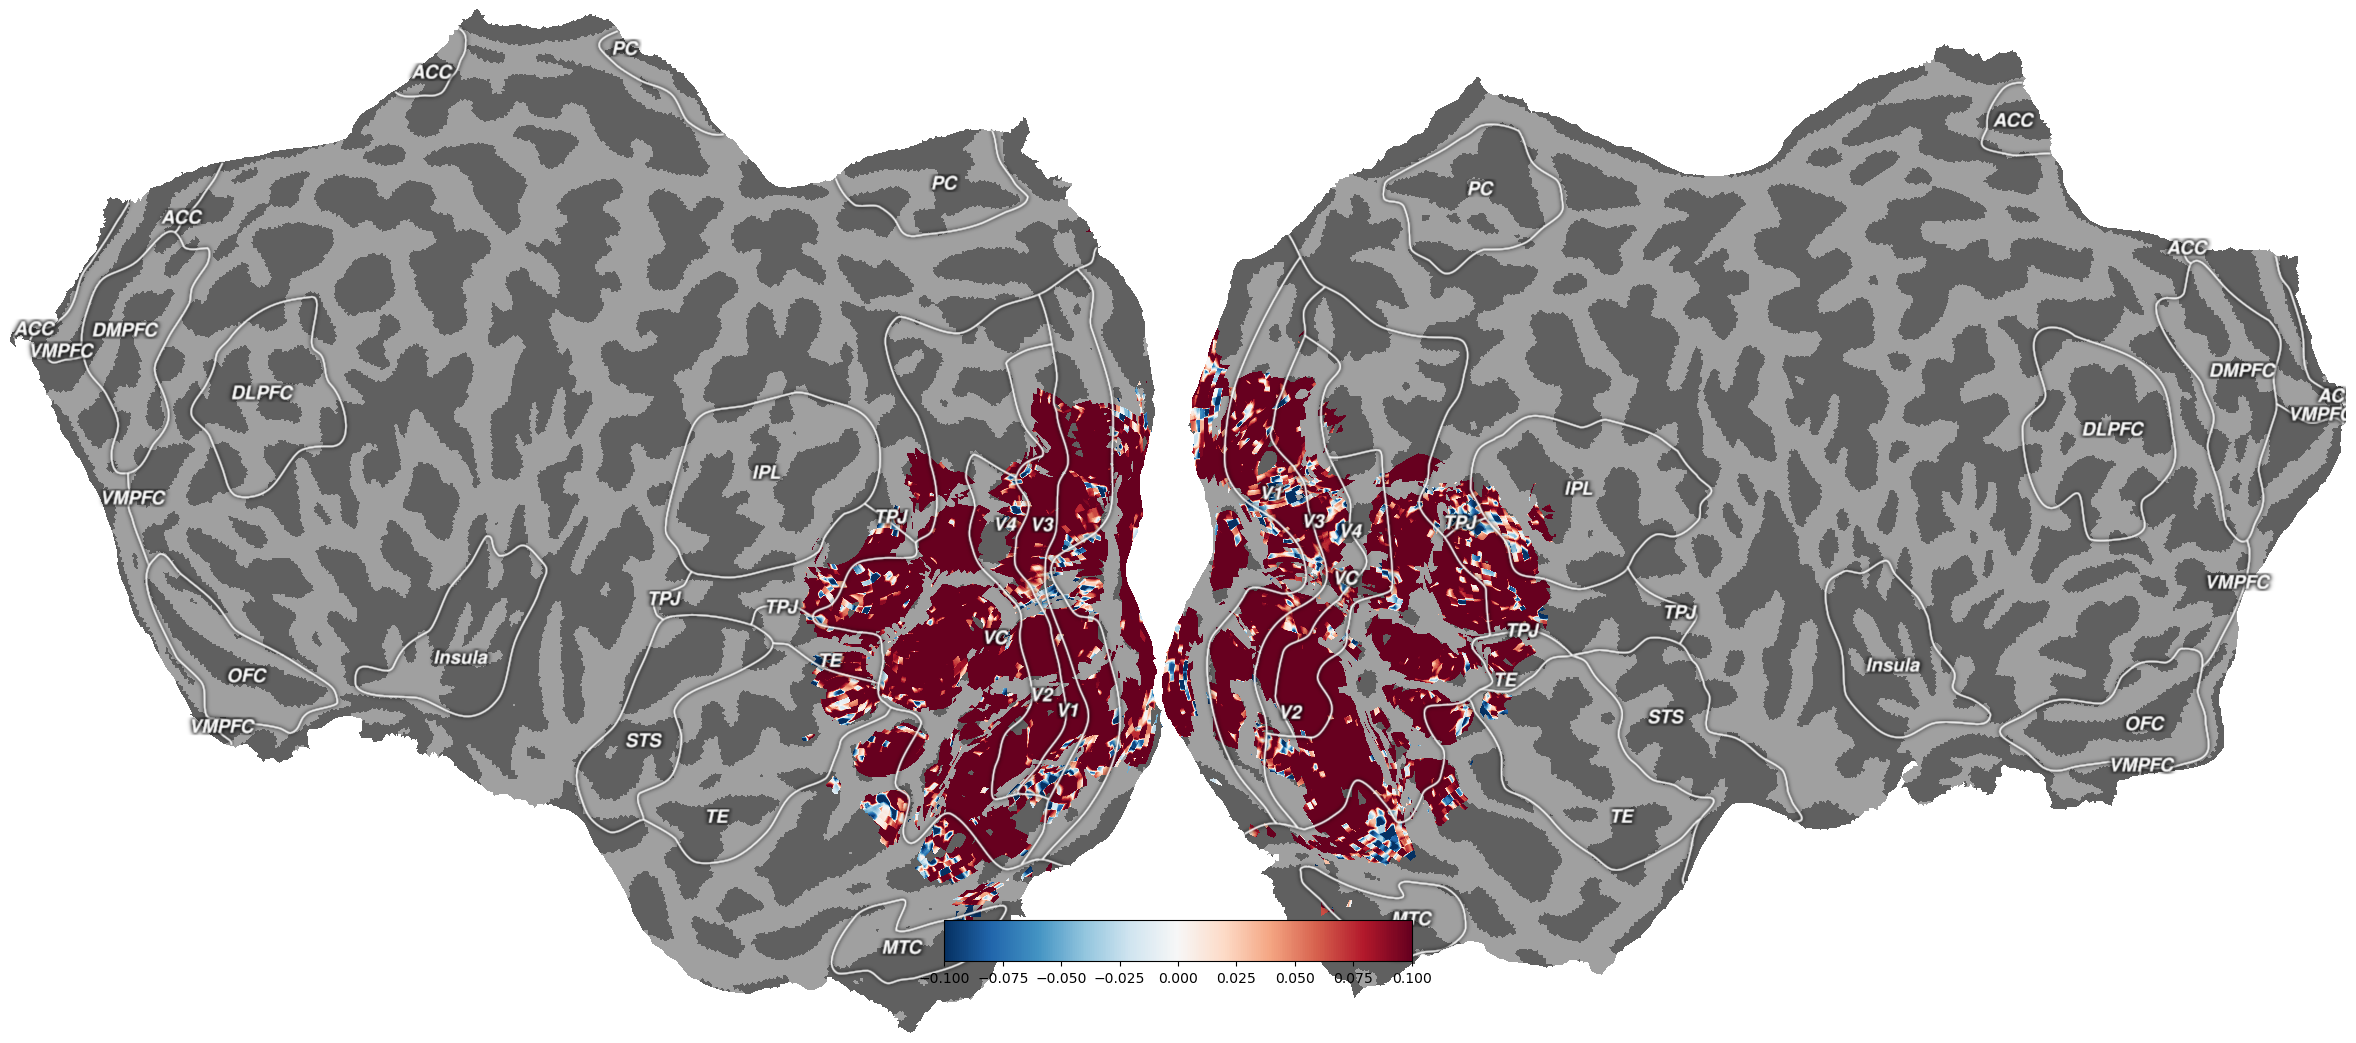

In [15]:
# Visualize the prediction accuracies on the cortical surface

cortex.quickshow(volume, with_curvature=True, with_colorbar=True, colorbar="right")
plt.show()